In [1]:
# Importando os módulos que serão utilizados
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
network=keras.models.load_model('Modelos treinados/Edge detection')

In [3]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,euler_equation,WENO_Z,network=None,compile_flag=True,p=2)
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_Numpy,euler_equation,WENO_JS,network=None,compile_flag=True,p=2)
def net_eq(x):
    a=slicer(FronteiraFixa(x,API_TensorFlow,1),5,API_TensorFlow)
    b=API_TensorFlow.unstack(a,axis=0)
    c=[]
    for i in b:
        c.append(network(i))
    return API_TensorFlow.stack(c,axis=0)[...,0]
Sim_conti, Sim_step_conti, DerivadaEspacial_conti, Get_weights_conti=create_simulation(API_Numpy,euler_equation,WENO_mix,network=net_eq,compile_flag=True,p=2)

In [4]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Δx = 0.01
CFL=0.5
Sim_layer = WENO_temporal(Δx, CFL, Δx*CFL, FronteiraFixa,euler_equation,WENO_JS)
Sim_net, Sim_step_net, DerivadaEspacial_net, Get_weights_net=tf.function(Sim_layer.Sim), tf.function(Sim_layer.Sim_step), tf.function(Sim_layer.DerivadaEspacial), tf.function(Sim_layer.Get_weights)

In [5]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([3,200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [6]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede temporal - 1.h5')

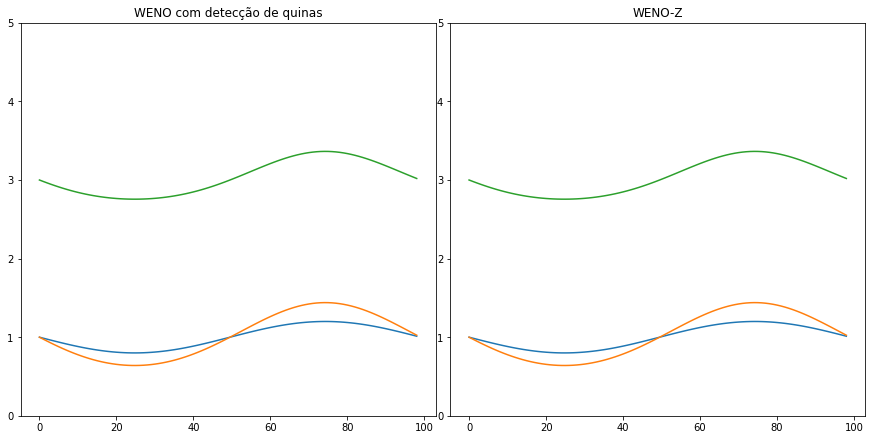

In [7]:
# Problema inicial
interval=2*np.pi
n_pts=100
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=10
BoundaryCondition=FronteiraPeriodica
ρ=np.sin(x)*0.2+1
u=ρ
p=x-x+1
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)
#Q=tf.expand_dims(Q,axis=0)

t=0
Δt=0.1
Q_final=Q
count=0

fig = plt.figure(1, constrained_layout=True, figsize=(6*2,6))

Qs=[Q_final+0,Q_final+0]
lines=[]
axs=[]
names=['WENO com detecção de quinas','WENO-Z']
Sims=[Sim_conti,Sim]
r=len(Qs)

for i,Q,name in zip(range(r),Qs,names):
    axs.append(fig.add_subplot(1, 2, i+1))
    axs[-1].set_ylim(0, 5)
    axs[-1].title.set_text(name)
    lines.append(axs[-1].plot(Q.T))

hfig = display(fig, display_id=True)

while t<FinalTime:
    for index,sim,line in zip(range(r),Sims,lines):
        Qs[index]=sim(Qs[index], Δt, Δx, CFL, BoundaryCondition)

        line[0].set_ydata(Qs[index][0])
        line[1].set_ydata(Qs[index][1])
        line[2].set_ydata(Qs[index][2])
        
    
    count+=1
    t+=Δt
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/euler edge 1 - t={}.png'.format(count))

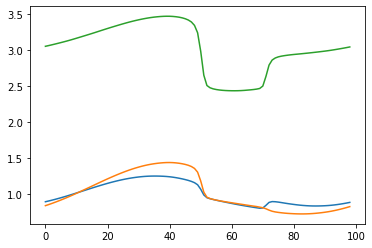

In [4]:
plt.plot(Q_final.T)

In [5]:
# Problema de Sod
interval=10
n_pts=200
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=2
BoundaryCondition=FronteiraFixa
ρ=np.where(x<0,0.125,1)
u=x-x
p=np.where(x<0,0.1,1)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[1]/Q[0]

Q_final=Sim(Q, FinalTime, Δx, CFL, BoundaryCondition)

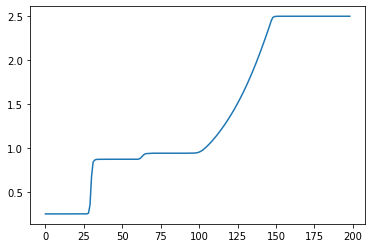

In [6]:
plt.plot(Q_final[2])

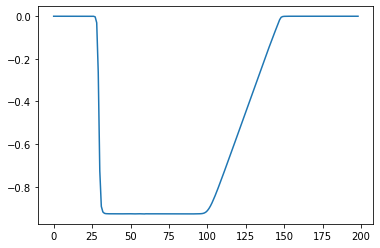

In [7]:
plt.plot(f(Q_final))

In [8]:
# Problema de Lax
interval=10
n_pts=200
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1.3
BoundaryCondition=FronteiraFixa
ρ=np.where(x<0,0.445,0.5)
u=np.where(x<0,0.698,0.0)
p=np.where(x<0,3.528,0.5710)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

Q_final=Sim(Q, FinalTime, Δx, CFL, BoundaryCondition)

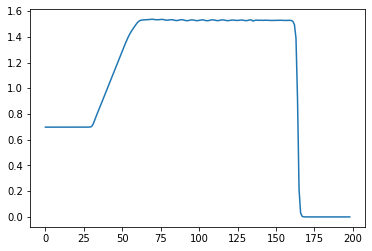

In [9]:
plt.plot(f(Q_final))

In [10]:
# Problema de 123
interval=10
n_pts=200
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
ρ=np.where(x<0,1,1)
u=np.where(x<0,-2,2)
p=np.where(x<0,0.4,0.4)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[0]

Q_final=Sim(Q, FinalTime, Δx, CFL, BoundaryCondition)

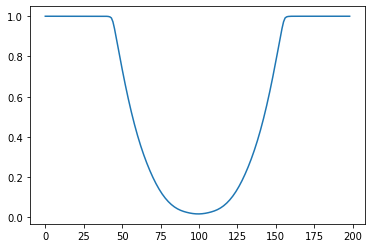

In [11]:
plt.plot(f(Q_final))

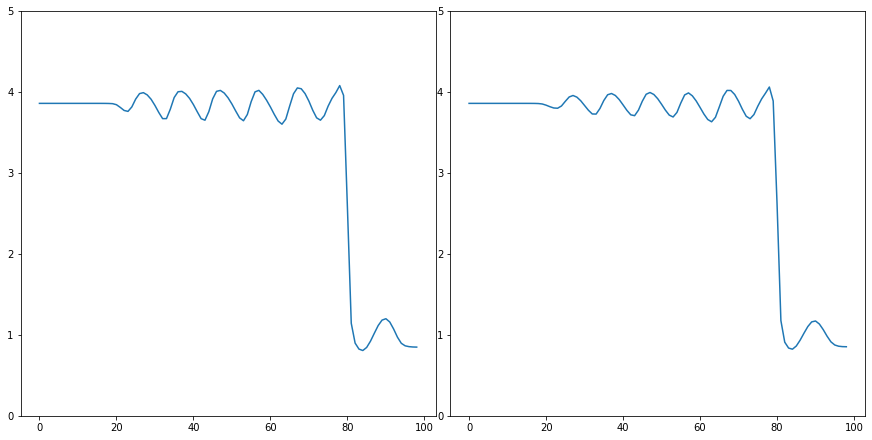

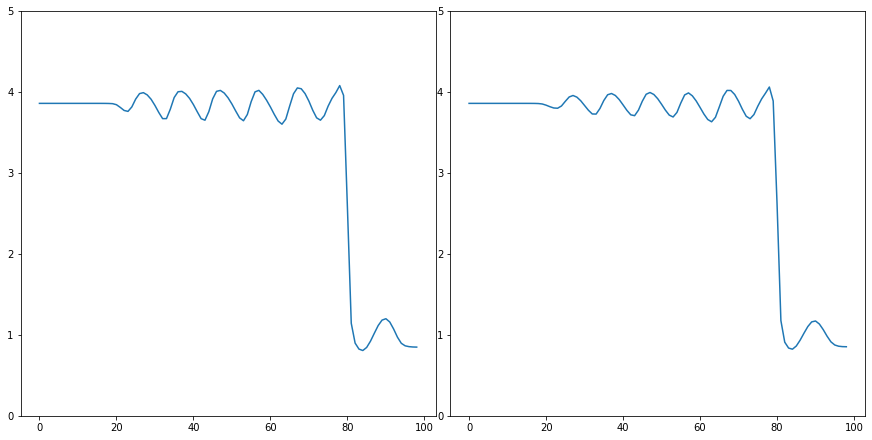

In [11]:
# Problema de Shock-density wave interaction
interval=10
n_pts=100
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
k=5
ρ=np.where(x< -4,3.857143,1+0.2*np.sin(k*x))
u=np.where(x< -4,2.629369,0)
p=np.where(x< -4,31/3,1)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[0]

t=0
Δt=0.01
Q_Z=Q[...]+0
Q_net=Q[...]+0
count=0

fig = plt.figure(1, constrained_layout=True, figsize=(6*2,6))
ax1  = fig.add_subplot(1, 2, 1)
ax1.set_ylim(0, 5)
line1 = ax1.plot(f(Q_Z))

ax2  = fig.add_subplot(1, 2, 2)
ax2.set_ylim(0, 5)
line2 = ax2.plot(f(Q_net))

hfig = display(fig, display_id=True)

while t<FinalTime:
    Q_Z=Sim(Q_Z, Δt, Δx, CFL, BoundaryCondition)

    Q_net=Sim_net(Q_net, Δt, Δx, CFL, BoundaryCondition)
    

    t+=Δt
    count+=1

    line1[0].set_ydata(f(Q_Z))
    line2[0].set_ydata(f(Q_net))
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/Shock-density wave - t={}.png'.format(count))

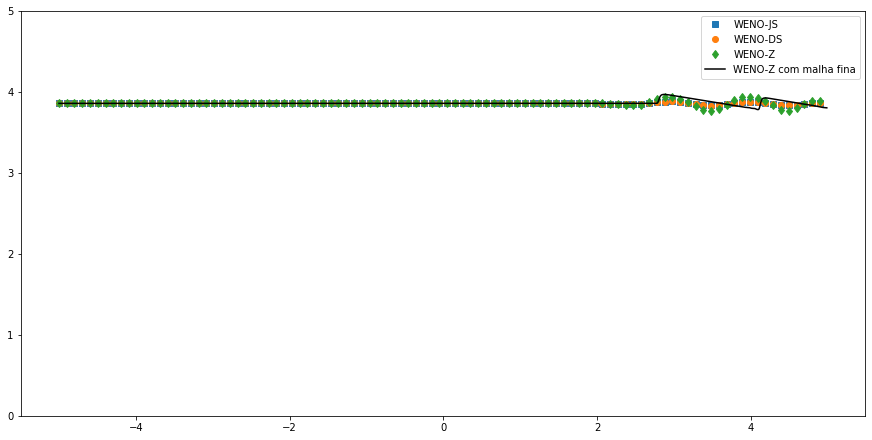

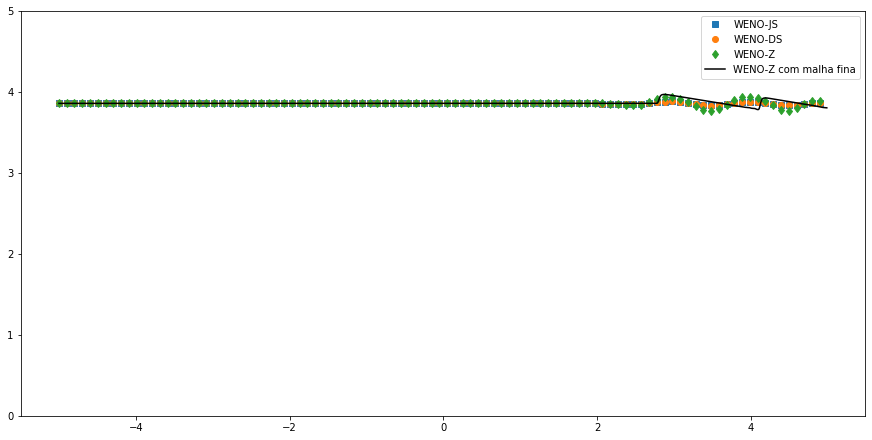

In [9]:
# Problema de Shock-density wave interaction
interval=10
n_pts=100
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
k=5
ρ=np.where(x< -4,3.857143,1+0.2*np.sin(k*x))
u=np.where(x< -4,2.629369,0)
p=np.where(x< -4,31/3,1)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

# Problema de Shock-density wave interaction
interval=10
n_pts=1000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
k=5
ρ=np.where(x< -4,3.857143,1+0.2*np.sin(k*x))
u=np.where(x< -4,2.629369,0)
p=np.where(x< -4,31/3,1)
E=p/(γ-1)+ρ*(u**2)/2

Q_ref=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[0]

t=0
Δt=0.01
Q_Z=Q[...]+0
Q_JS=Q[...]+0
Q_net=Q[...]+0
Q_ref=Q_ref+0
count=0

fig = plt.figure(1, constrained_layout=True, figsize=(6*2,6))
ax1  = fig.add_subplot(1, 1, 1)
ax1.set_ylim(0, 5)
interval=10
n_pts=100
Δx=interval/(n_pts-1)

x=np.arange(-interval/2,interval/2,Δx)
line2 = ax1.plot(x,f(Q_Z),'s',label='WENO-JS')
line1 = ax1.plot(x,f(Q_net),'o',label='WENO-DS')
line3 = ax1.plot(x,f(Q_Z),'d',label='WENO-Z')

interval=10
n_pts=1000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
line4 = ax1.plot(x,f(Q_ref),'-',color='black',label='Sol. ref.')

ax1.legend()

hfig = display(fig, display_id=True)

while t<FinalTime:
    print(str(count).zfill(4),end='\r')
    Q_Z=Sim(Q_Z, Δt, Δx, CFL, BoundaryCondition)
    Q_JS=Sim_JS(Q_JS, Δt, Δx, CFL, BoundaryCondition)

    Q_net=Sim_net(Q_net, Δt, Δx, CFL, BoundaryCondition)

    Q_ref=Sim(Q_ref, Δt, Δx/10, CFL, BoundaryCondition)
    

    t+=Δt
    count+=1

    line1[0].set_ydata(f(Q_net))
    line2[0].set_ydata(f(Q_JS))
    line3[0].set_ydata(f(Q_Z))
    line4[0].set_ydata(f(Q_ref))
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/Shock-density wave/Shock-density wave - t={}.png'.format(str(count).zfill(4)))

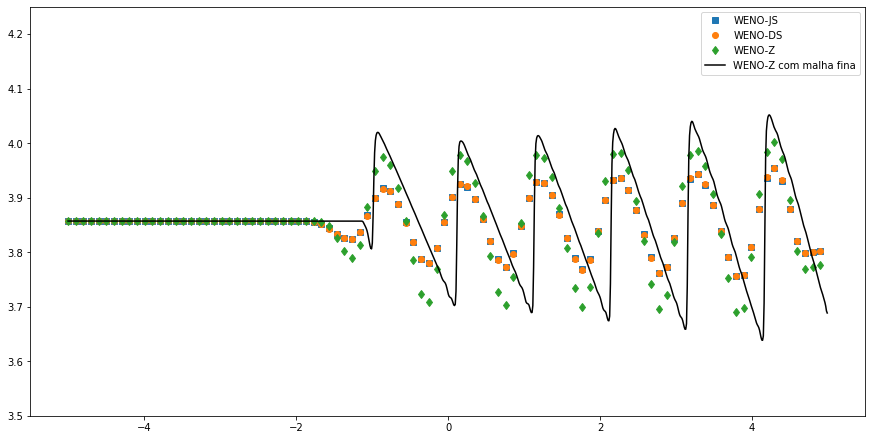

In [10]:
# Problema de Shock-density wave interaction
interval=10
n_pts=100
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
k=5
ρ=np.where(x< -4,3.857143,1+0.2*np.sin(k*x))
u=np.where(x< -4,2.629369,0)
p=np.where(x< -4,31/3,1)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

# Problema de Shock-density wave interaction
interval=10
n_pts=1000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=1
BoundaryCondition=FronteiraFixa
k=5
ρ=np.where(x< -4,3.857143,1+0.2*np.sin(k*x))
u=np.where(x< -4,2.629369,0)
p=np.where(x< -4,31/3,1)
E=p/(γ-1)+ρ*(u**2)/2

Q_ref=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[0]

t=0
Δt=0.01
Q_Z=Q[...]+0
Q_JS=Q[...]+0
Q_net=Q[...]+0
Q_ref=Q_ref+0
count=0

fig = plt.figure(1, constrained_layout=True, figsize=(6*2,6))
ax1  = fig.add_subplot(1, 1, 1)
ax1.set_ylim(3.5, 4.25)
interval=10
n_pts=100
Δx=interval/(n_pts-1)

x=np.arange(-interval/2,interval/2,Δx)
line2 = ax1.plot(x,f(Q_Z),'s',label='WENO-JS')
line1 = ax1.plot(x,f(Q_net),'o',label='WENO-DS')
line3 = ax1.plot(x,f(Q_Z),'d',label='WENO-Z')

interval=10
n_pts=1000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
line4 = ax1.plot(x,f(Q_ref),'-',color='black',label='Sol. ref.')

ax1.legend()

hfig = display(fig, display_id=True)

while t<FinalTime:
    print(str(count).zfill(4),end='\r')
    Q_Z=Sim(Q_Z, Δt, Δx, CFL, BoundaryCondition)
    Q_JS=Sim_JS(Q_JS, Δt, Δx, CFL, BoundaryCondition)

    Q_net=Sim_net(Q_net, Δt, Δx, CFL, BoundaryCondition)

    Q_ref=Sim(Q_ref, Δt, Δx/10, CFL, BoundaryCondition)
    

    t+=Δt
    count+=1

    line1[0].set_ydata(f(Q_net))
    line2[0].set_ydata(f(Q_JS))
    line3[0].set_ydata(f(Q_Z))
    line4[0].set_ydata(f(Q_ref))
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/Shock-density wave zoomed/Shock-density wave zoomed - t={}.png'.format(str(count).zfill(4)))

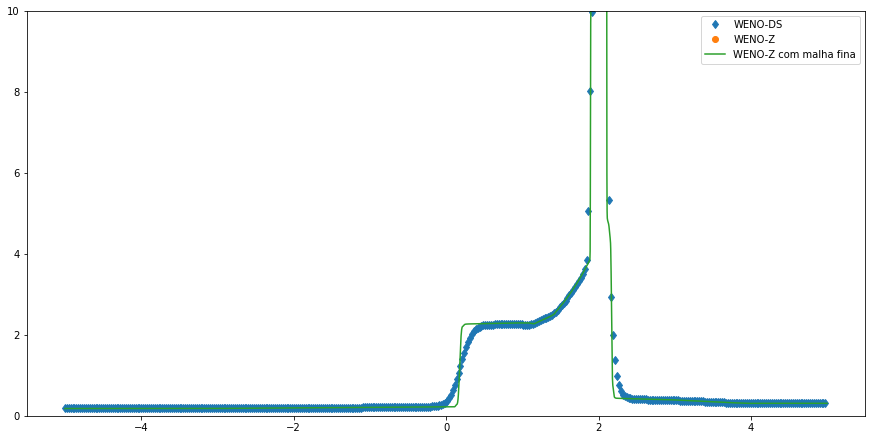

In [9]:
# Problema de Blast wave
n_pts=400
Δx=1/(n_pts-1)
x=np.arange(0,1,Δx)
γ=1.4
CFL=0.5
FinalTime=0.07
BoundaryCondition=FronteiraReflexiva
k=5
ρ=x-x+1
u=x-x
p=np.where(x< 0.1,1000,0.01)
p=np.where(0.9<=x,100,p)
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=0)

# Problema de Blast wave
n_pts=4000
Δx=1/(n_pts-1)
x=np.arange(0,1,Δx)
γ=1.4
CFL=0.5
FinalTime=0.07
BoundaryCondition=FronteiraReflexiva
k=5
ρ=x-x+1
u=x-x
p=np.where(x< 0.1,1000,0.01)
p=np.where(0.9<=x,100,p)
E=p/(γ-1)+ρ*(u**2)/2

Q_ref=np.stack([ρ,ρ*u,E],axis=0)

f=lambda Q: Q[0]

t=0
Δt=0.01
Q_Z=Q[...]+0
Q_net=Q[...]+0
Q_ref=Q_ref+0
count=0

fig = plt.figure(1, constrained_layout=True, figsize=(6*2,6))
ax1  = fig.add_subplot(1, 1, 1)
ax1.set_ylim(0, 10)
interval=10
n_pts=400
Δx=interval/(n_pts-1)

x=np.arange(-interval/2,interval/2,Δx)
line1 = ax1.plot(x,f(Q_net),'d',label='WENO-DS')
line2 = ax1.plot(x,f(Q_Z),'o',label='WENO-Z')

interval=10
n_pts=4000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
line3 = ax1.plot(x,f(Q_ref),'-',label='WENO-Z com malha fina')

ax1.legend()

hfig = display(fig, display_id=True)

while t<FinalTime:
    print(count,end='\r')
    Q_Z=Sim(Q_Z, Δt, Δx, CFL, BoundaryCondition)

    Q_net=Sim_net(Q_net, Δt, Δx, CFL, BoundaryCondition)

    Q_ref=Sim(Q_ref, Δt, Δx/10, CFL, BoundaryCondition)
    

    t+=Δt
    count+=1

    line1[0].set_ydata(f(Q_net))
    line2[0].set_ydata(f(Q_Z))
    line3[0].set_ydata(f(Q_ref))
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/blast wave - t={}.png'.format(count))

In [10]:
Q_final.shape

(3, 99)

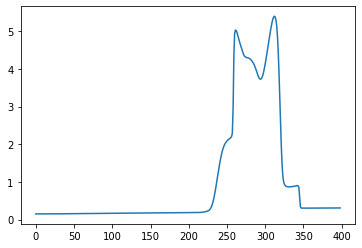

In [4]:
plt.plot(f(Q_final))

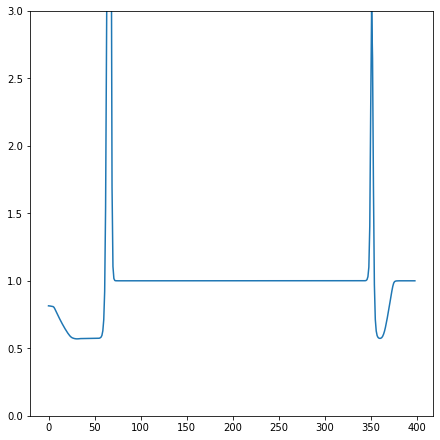

KeyboardInterrupt: 

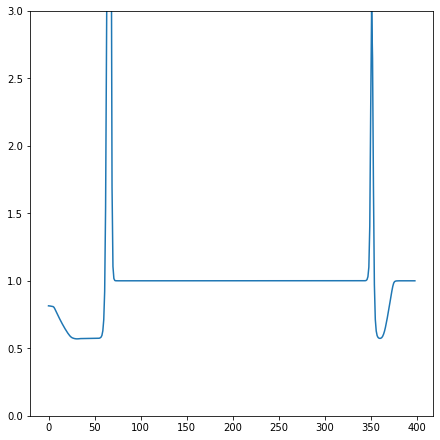

In [8]:
fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(0,3)
line = ax.plot(np.squeeze(f(Q)))
hfig = display(fig, display_id=True)

Q_final=Q
t=0
while t<FinalTime:
    Q_final=Sim(Q_final, 0.001, Δx, CFL, BoundaryCondition)
    t+=0.001

    line[0].set_ydata(f(Q_final))
    fig.canvas.draw()
    hfig.update(fig)